# Guía 6 - Identificación de sistemas - Filtrado de series temporales

En las siguientes secciones realizaremos simulaciones de procesos aleatorios. Seguidamente, las analizaremos en el dominio de la frecuencia y evaluaremos cómo se transforman cuando pasan por un sistema lineal. Estas transformaciones habilitan el uso de sistemas lineales como filtros.  

## Simulación de un proceso AR(1)

Vamos a generar una serie temporal a partir de la definición de un proceso AR(1) y un ruido gaussiano $w$ 

$$x[t] = \alpha x[t-1] + w[t]$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

NT=2047
ts = np.arange(NT)
mu = 0
sigma = 1
w = mu + sigma*np.random.randn(NT)
alpha = 0.9
x = np.zeros(NT)
x[0] = w[0]

# Generamos la secuencia
for t in ts[1:]:
    x[t] = alpha*x[t-1] + w[t]

Para facilitar la representación del espectro definimos una función que se encarga de realizar la FFT y el suavizado del periodograma.

In [2]:
def power_spectrum(time_series, half_window_size=1):

    xt = time_series
    hws = half_window_size
    NTimes = time_series.size
    
    # FFT de la señal
    xf = np.fft.rfft(xt)
    narmonics = xf.size
    print(f'Cantidad de armónicos: {narmonics}')
    sample_rate = 1
    armonics = np.fft.rfftfreq(NTimes, d=1./sample_rate)

    # Ajustamos la varianza
    xf_adj = xf * 2 / NTimes
    sqamp = np.real(xf_adj)**2 + np.imag(xf_adj)**2
    print(f'Varianza de la señal: {np.var(xt):.2e}')
    print(f'Identidad de Parseval: {0.5*np.sum(sqamp[1:]):.2e}')
    
    # Moving window smoothing
    # Daniell's window
    dw = np.ones(2*hws+1)
    dw[0] = 0.5*dw[0]
    dw[1] = 0.5*dw[-1]
    ps = 0.5*np.convolve(NTimes*sqamp, dw, mode='same')[hws::2*hws+1] / (2*hws)
    fs = armonics[hws::2*hws+1]

    weights = np.repeat(np.float32(2*hws+1)/NTimes,ps.size)
    print(f'Integración rápida del espectro {np.dot(ps,weights):.2e}')
    return [fs, ps]
    

Obtenemos las frecuencias de los armónicos y los correspondientes cuadrados de las amplitudes (potencias)

In [3]:
fs, ps = power_spectrum(x, 7)

Cantidad de armónicos: 1024
Varianza de la señal: 5.91e+00
Identidad de Parseval: 5.91e+00
Integración rápida del espectro 6.00e+00


Comparamos la representación en el dominio del tiempo, la función de autocorrelación y el espectro de potencias

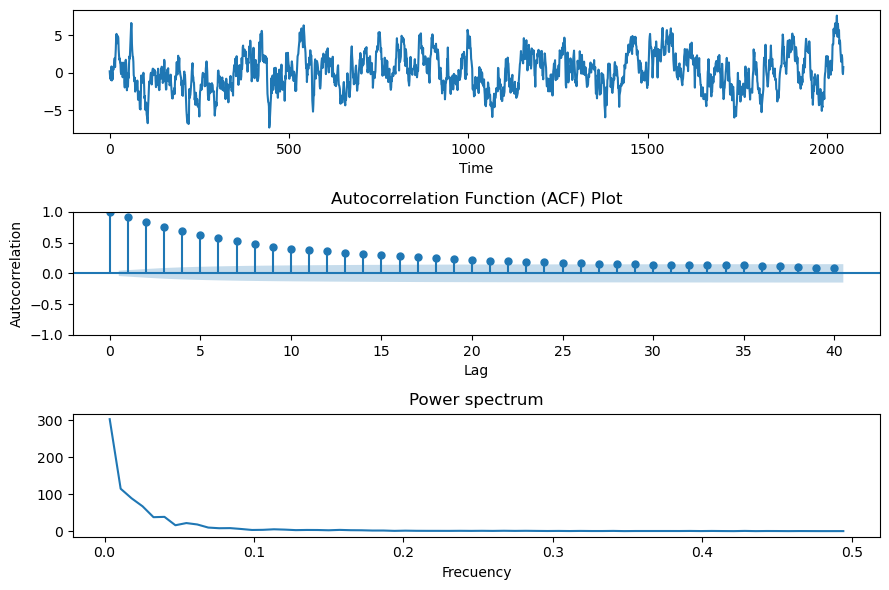

In [4]:
fig, ax = plt.subplots(3,1, figsize=(9,6))
ax[0].plot(ts, x)
ax[0].set_xlabel('Time')

plot_acf(x, lags=40, ax=ax[1])
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Autocorrelation")
ax[1].set_title('Autocorrelation Function (ACF) Plot')

ax[2].plot(fs, ps)
ax[2].set_xlabel('Frecuency')
ax[2].set_title('Power spectrum')

plt.tight_layout()

Se observa que la autocorrelación decae exponencialmente por la definición del proceso. Además, vemos que el proceso AR(1) no responde a frecuencias altas (filtra las altas frecuencias). 

## Simulación de un proceso AR(2)

Vamos a generar una serie temporal a partir de la definición de un proceso AR(2) y un ruido gaussiano $w$ 

$$x[t] = x[t-1] - \alpha x[t-2] + w[t]$$


In [5]:
alpha = 0.6
x = np.zeros(NT)
x[0] = w[0]
x[1] = w[1]

# Generamos la secuencia
for t in ts[2:]:
    x[t] = x[t-1] - alpha*x[t-2] + w[t]

Obtenemos las frecuencias de los armónicos y los correspondientes cuadrados de las amplitudes (potencias)

In [6]:
fs, ps = power_spectrum(x, 7)

Cantidad de armónicos: 1024
Varianza de la señal: 2.70e+00
Identidad de Parseval: 2.70e+00
Integración rápida del espectro 2.69e+00


Comparamos la representación en el dominio del tiempo, la función de autocorrelación y el espectro de potencias

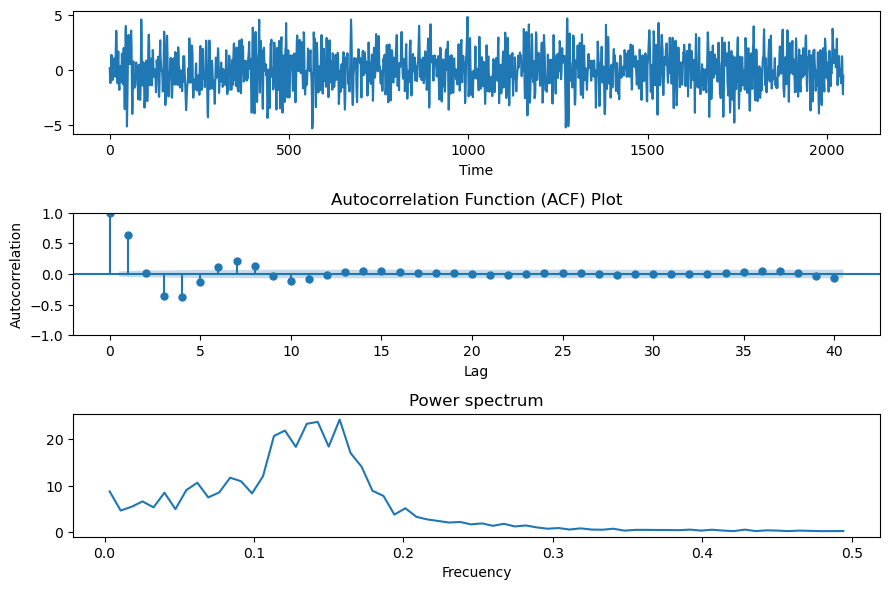

In [7]:
fig, ax = plt.subplots(3,1, figsize=(9,6))
ax[0].plot(ts, x)
ax[0].set_xlabel('Time')

plot_acf(x, lags=40, ax=ax[1])
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Autocorrelation")
ax[1].set_title('Autocorrelation Function (ACF) Plot')

ax[2].plot(fs, ps)
ax[2].set_xlabel('Frecuency')
ax[2].set_title('Power spectrum')

plt.tight_layout()

Un proceso AR(2) se puede interpretar como una ecuación de diferencias de segundo orden que describe el movimiento de un sistema amortiguado simple tal como una masa y un resorte sujeta a una secuencia de impulsos de ruido blanco. 

El espectro de potencias muestra un pico para la frecuencia natural del sistema (La frecuencia a la que la masa oscilaría si el resorte es extendido y liberado). 

## Espectro de un proceso aleatorio

Si bien podemos calcular el espectro de una serie temporal finita, no tenemos una fórmula algebraica para definir el espectro de un proceso aleatorio subyacente.

La definición del espectro de un proceso estocástico sigue de considerar el valor esperado para el periodograma suavizado

$$\left| X_k \right|^2 \rightarrow \Gamma(\omega)$$

$$\Gamma(\omega) = \frac{1}{2 \pi} \sum_{k=-\infty}^{\infty} \gamma_k e^{-i\omega k}, \,\,\,\,\,\,\,\, -\pi \le \omega \le \pi$$

### Espectro de ruido blanco

Para una serie de valores aleatorios independientes con media nula y varianza $\sigma^2$ 

$$\gamma_k = \left\{ 
\begin{array}{ll}
\sigma^2 & k=0\\
0        & \mathrm{en\, otro\, caso}
\end{array}\right.$$

se obtiene

$$\Gamma(\omega) = \frac{\sigma^2}{2\pi}, \,\,\,\,\,\,\,\, -\pi \le \omega \le \pi$$

## Espectro de un proceso AR(p)

Si consideramos la parte determinística de un proceso AR(p)

$$x_t - \alpha_1 x_{t-1} - \cdots - \alpha_p x_{t-p} = e^{i\omega t}$$

y asumimos una solución de la forma $A e^{i\theta} e^{i\omega t}$ entonces

$$A \left(1 - \alpha_1 e^{i\omega} - \cdots - \alpha_p e^{i\omega p}\right) = 1$$
o 
$$A  = \left(1 - \alpha_1 e^{i\omega} - \cdots - \alpha_p e^{i\omega p}\right)^{-1}$$

### Sistemas lineales invariantes temporales

La respuesta de un sistema LTI (linear time-invariant) para un coseno es un coseno de la misma frecuencia con una amplitud proporcional a la señal de entrada. El cociente entre la señal de salida y la de entrada se conoce como ganancia. Además, puede presentarse un corrimiento de fase. 

![Filtro pasa bajos](Figs/filtro_pasa_bajos.png)

Si ${x}$ representa la serie de entrada y ${y}$ representa la serie de salida, $\mathcal{L}$ el operador de transformación $O$ se define como

$$\{y[n]\} \equiv O\{x[n]\}$$

Para un sistema lineal, $O$ debe satisfacer

$$O\left\{\sum _{k=-\infty }^{\infty }c_{k}x[k]\right\}=\sum _{k=-\infty }^{\infty }c_{k}O\{x[k]\}$$

y por el requerimiento de invariancia temporal

$$O\{x[n-k]\} = \{y[n-k]\}$$

(ver también [Linear time-invariant system](https://en.wikipedia.org/wiki/Linear_time-invariant_system) y [Chapter 2 Linear Time-Invariant Systems](https://www.site.uottawa.ca/~jpyao/courses/ELG3120_files/ch2.pdf)) Luego, empleando la transformada de Fourier se halla la relación en el espacio de frecuencias entre la serie de entrada y la de salida

$$C_{yy}(\omega) = G^2(\omega) C_{xx}(\omega)$$

Cuando la salida $y(\omega)$ se obtiene de un proceso aleatorio $x(omega)$ que pasa por un sistema lineal será 

$$\Gamma_y(\omega) = \mathrm{G}^2(\omega) \Gamma_x(\omega)$$

En general, para un proceso ARMA(p,q) se satisface

$$\Gamma_y(\omega) = \frac{\sigma^2}{2\pi} \left| \frac{1+\sum_{l=1}^{q} \beta_l e^{-iwl}}{1+\sum_{m=1}^{p} \beta_m e^{-iwm}} \right|^2$$


## Ejemplo de espectro para el proceso AR(2)

Vamos a obtener la ganancia teórica para el proceso AR(2) que definimos anteriormente

$$G^2(\omega) =  \left| \frac{1}{1 - e^{-iw} - \alpha e^{-iw2}} \right|^2$$

Recordando que para un número complejo $u=a+ib$ se cumple

$$\left(\frac{1}{u}\right)\left(\frac{1}{u}\right)^* = \left|\frac{1}{a^2 + b^2}\right|$$

la ganacia en función de la frecuencia es

$$G^2(\omega) = \frac{1}{2+\alpha^2 + 2(\alpha-1)\cos(\omega) - 2\alpha\cos(2\omega)}$$

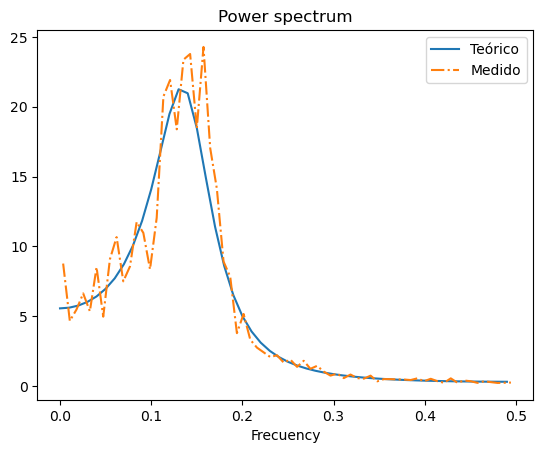

In [8]:
repstep = 0.01
omega = 2*np.pi*np.arange(0, 0.5, repstep)
alpha=-0.6

A_2 = 1 /( 2+alpha**2 + 2*(alpha-1)*np.cos(omega) - 2*alpha*np.cos(2*omega) )

# multiplico por 2 porque considero solo el rango 0 < omega < 0.5

plt.plot(omega/(2*np.pi), 2*A_2, label='Teórico') 
#ps = np.convolve(NT*sqamp, np.ones(2*mw+1), mode='same')/(2*mw+1)
#fs = armonics/NT
plt.plot(fs, ps, '-.', label='Medido')
plt.xlabel('Frecuency')
plt.title('Power spectrum')
plt.legend(loc='best')

Observamos un buen grado de solapamiento entre la curva teórica y la que resulta de simular el proceso AR(2).

In [9]:
weights = np.repeat(repstep,len(A_2))
print(f'Área bajo el espectro teórico: {np.dot(2*A_2,weights):.2e}')

Área bajo el espectro teórico: 2.59e+00


**Ejercicio**

1. Obtener la ganancia en función de la frecuencia para el proceso AR(1). Comparar la respuesta en frecuencia del proceso simulado AR(1) y la ganancia teórica.
2. Probar que la ecuación diferencial de segundo orden para un oscilador armónico amortiguado forzado con un ruido gaussiano resulta equivalente a un modelo AR(2) 

$$\ddot{x} + 2\zeta\Omega\dot{x} + \Omega^2x = w$$

con $\zeta$ el amortiguamiento, $\Omega$ la frecuencia natural cuando se sustituyen las derivadas por diferencias

$$\ddot{x} = x_t - 2 x_{t-1} + x_{t-2}, \,\,\,\,\,\,\,\, \dot{x} = x_t - x_{t-1}$$

# Filtrado con modelos autorregresivos

Los modelos AR(p) pueden emplearse para filtrar ciertas señales en el dominio del tiempo: el modelo AR(1) se comporta como un filtro pasa bajos; el modelo AR(2) puede opera como un filtro pasa banda. 

Ciertamente, vimos que se pueden anular armónicos específicas de la serie transformada al dominio de la frecuencia. Sin embargo, estos filtros basados en modelos ARIMA permiten transformar la serie a medida que avanza en el tiempo.


## Exponential moving average (EMA)

El filtrado de media de ventana móvil exponencial es una técnica muy popular para remover ruido de alta frecuencia (ver también [Moving average](https://en.wikipedia.org/wiki/Moving_average) y el artículo [Exponential moving average](https://tttapa.github.io/Pages/Mathematics/Systems-and-Control-Theory/Digital-filters/Exponential%20Moving%20Average/Exponential-Moving-Average.pdf)). Se puede equiparar con un modelo ARIMA(0,1,1). La idea es promediar con un peso regulable el valor actual de la señal $s$ y el valor $x$ del paso anterior

$$x[t] = \alpha s[t] + (1-\alpha)x[t-1]$$

Es fácil reconocer un modelo AR(1) con

$$\left(1 - (1-\alpha) B\right) x[t] = \alpha s[t]$$

con $B$ el operador de traslación de un paso en el tiempo. Con esta expresión podemos calcular la gancia por definición

$$G^2(\omega) =  \left| \frac{\alpha}{1 - (1-\alpha)e^{-iw} }\right|^2$$

Operando con los números complejos obtenemos la ganacia en función de la frecuencia

$$G^2(\omega) = \frac{\alpha^2}{1 + (1-\alpha)^2 - 2(1-\alpha)\cos(\omega)}$$

### Ejemplo de filtrado por EMA

Proponemos una serie que combina una función de baja frecuencia, otra de alta frecuencia y ruido gaussiano

Text(0.5, 0, 'time')

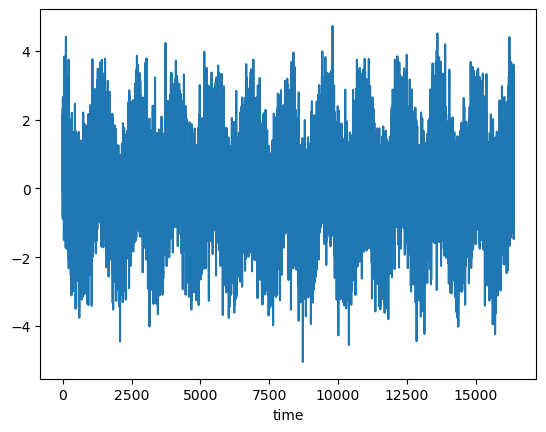

In [10]:
import numpy as np
import matplotlib.pyplot as plt

NT = 16383
t = np.arange(0, NT)
Delta_t = 1

mu = 0
sigma = 1.0
a_baja = 1.0
f_baja = np.float32(12) / NT
a_alta = 0.6
f_alta = 0.4
phi_b = 2 * np.pi * 0.125
s_t = a_baja * np.cos(2 * np.pi * f_baja * t ) + a_alta * np.cos(2 * np.pi * f_alta * t  + phi_b) 
s_t = s_t + sigma * np.random.randn(len(t)) + mu

plt.plot(t, s_t)
plt.xlabel('time')

Vemos cómo se ve en el dominio de la frecuencia

In [11]:
fs, ps = power_spectrum(s_t, 5)

Cantidad de armónicos: 8192
Varianza de la señal: 1.69e+00
Identidad de Parseval: 1.69e+00
Integración rápida del espectro 1.76e+00


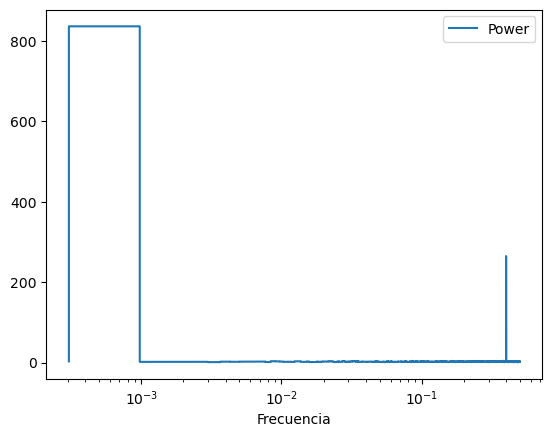

In [12]:
plt.xscale('log')
plt.step(fs, ps, label='Power')
plt.xlabel('Frecuencia')
plt.legend(loc='upper right')

Analizamos como quedó la señal luego del filtrado con EMA

Text(0.5, 0, 'time')

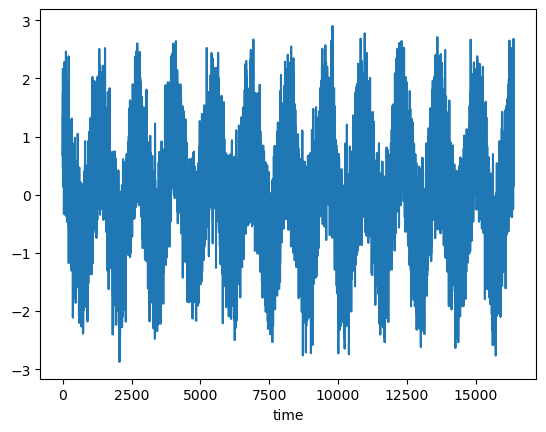

In [13]:
alpha = 0.5
x_t = np.zeros_like(s_t)
x_t[0] = s_t[0]
for tt in t[1:]:
    x_t[tt] = alpha * s_t[tt] + (1-alpha)*x_t[tt-1]

plt.plot(t, x_t)
plt.xlabel('time')

Cantidad de armónicos: 8192
Varianza de la señal: 8.67e-01
Identidad de Parseval: 8.67e-01
Integración rápida del espectro 9.22e-01


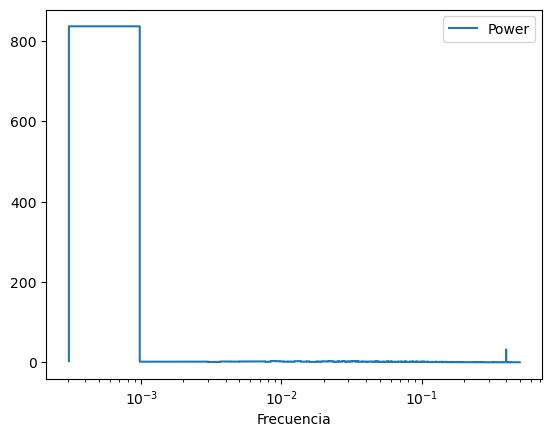

In [14]:
fs, ps = power_spectrum(x_t, 5)
plt.xscale('log')
plt.step(fs, ps, label='Power')
plt.xlabel('Frecuencia')
plt.legend(loc='upper right')

**Ejercicios**
1. La frecuencia de corte se define como la frecuencia a la cual la potencia se reduce a la mitad. Hallar la frecuencia de corte para el ejemplo anterior a partir de la fórmula para $G^2(\omega)$. ¿Cómo depende del valor de $\alpha$? Algunos autores proponern optimizar $\alpha$ minimizando el valor de $(x_t - s_{t+1})^2$. Nota: Muchas veces la ganacia se representa en escala logarítmica en términos de decibelles (dB) $10\log(G^2)$. Así, cuando la $G^2$ se reduce a la mitad corresponde una reducción de aproximadamente $10\log (0.5 G^2) = 10\log (G^2) + 10\log (0.5) = 10\log (G^2) - 3dB$.
2. A partir de la serie de temperaturas máximas de Castelar aplicar un filtro EMA para recuperar solamente la variación anual.
3. Se puede interretar que el filtro EMA predice el valor de la variable $x$ un paso adelante. Dicho valor se puede reusar para obtener otra predicción dos pasos adelante reemplazando $s[t]$ por su media. Aplicar esta técnica para continuar la serie de temperaturas máximas asumiendo la media de $s[t]=0$.
4. Los modelos AR(p) pueden pensarse como la versión discreta (digital) de los filtros analógicos. Un filtro pasa bajos analógico convencional está formado por una resistencia y una bobina. Su ecuación diferencial de primer orden se puede discretizar y nos conduce a una expresión equivalente a un AR(1). Si se sumar en cascada un segundo filtro digital AR(1)  ¿Se puede transformar esta configuración en un proceso AR(2)? ¿Cómo es la ganacia del conjunto en función de la frecuencia? Comparar el poder de filtrado de un un modelo de orden 1 con otro de orden 2. 